In [1]:
%matplotlib inline
import numpy
import pandas
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

from retina2 import *

/home/oalenkin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('../data/hits.csv', index_col=0)

# Stations 1&2

In [4]:
from combination import Combinator
from metrics import TracksReconstractionMetrics, CombinatorQuality

In [5]:
%%time
event_ids = numpy.unique(data.EventID.values)

tracks12 = {}
tracks34 = {}
tracks_comb = {}

tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Y34', 'Combination', 'Matching'])

for event_id in event_ids:
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    # Tracks reconstruction before the magnet
    tr2d12 = RetinaTrackReconstruction(sigma_from=0.8, sigma_to=0.4, pre_sigma=0.4, stopping_criteria=0.00001, inlier_treshold=0.2)
    tr2d12.fit(event12[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, event12.dist2Wire.values)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    tr2d34 = RetinaTrackReconstruction(sigma_from=0.8, sigma_to=0.4, pre_sigma=0.4, stopping_criteria=0.00001, inlier_treshold=0.2)
    tr2d34.fit(event34[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, event34.dist2Wire.values)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
    
    # Save the reconstructed tracks
    tracks12[event_id] = {'labels':labels12, 'params':tracks_params12}
    tracks34[event_id] = {'labels':labels34, 'params':tracks_params34}
    
    
    # Combination of the tracks before and after the magnet
    comb = Combinator()
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    try:
        cq = CombinatorQuality()
        cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)

        combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                               cq.reco_eff_, 
                                                               cq.ghost_rate_, 
                                                               cq.clone_rate_, 
                                                               cq.n_combined_]

        for num in range(len(cq.check_tracks_combinations_)):

            combinations_true.loc[len(combinations_quality)] = [event_id, 
                                                                   cq.check_tracks_combinations_[num], 
                                                                   cq.true_pdg_codes_[num], 
                                                                   cq.true_charges_[num],
                                                                   cq.check_charges_[num], 
                                                                   cq.true_inv_momentums_[num], 
                                                                   cq.momentums_err_[num],
                                                                   cq.labels_[num]]



        # Overall quality
        pass_stages.loc[len(pass_stages)] = numpy.array([1, 
                                                         (trm12.recognition_efficiency_ == 1)*1,
                                                         (trm34.recognition_efficiency_ == 1)*1, 
                                                         (cq.n_combined_ >= 2)*1,
                                                         (cq.reco_eff_ == 1)*1]).cumprod()
        
        if not (trm12.recognition_efficiency_ == 1):
            print 1, event_id
        elif not (trm34.recognition_efficiency_ == 1):
            print 2, event_id
        elif not (cq.n_combined_ >= 2):
            print 3, event_id
            
            

        # Save the tracks combination
        tracks_comb[event_id] = {'tracks_combinations':comb.tracks_combinations_, 
                                 'charges':comb.charges_, 
                                 'inv_momentums':comb.inv_momentums_}
        
    except:
        
        print event_id

3 27
3 85
3 143
3 270
3 1311
3 1528
3 1722
3 1756
3 2002
3 2040
3 2455
3 2590
3 3085
3 3498
2 3670
3 3749
3 3781
3 3942
3 4175
3 4342
3 4423
3 4439
2 4490
3 4566
3 4580
3 4634
CPU times: user 39min 3s, sys: 1.72 s, total: 39min 5s
Wall time: 39min


# Quality

# Stations 1&2

## track efficiency

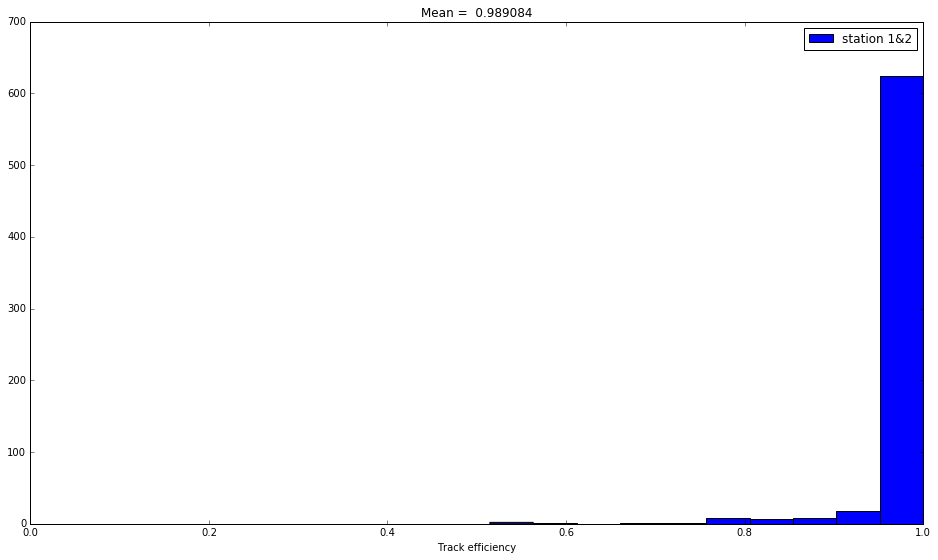

In [6]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

## reconstruction efficiency

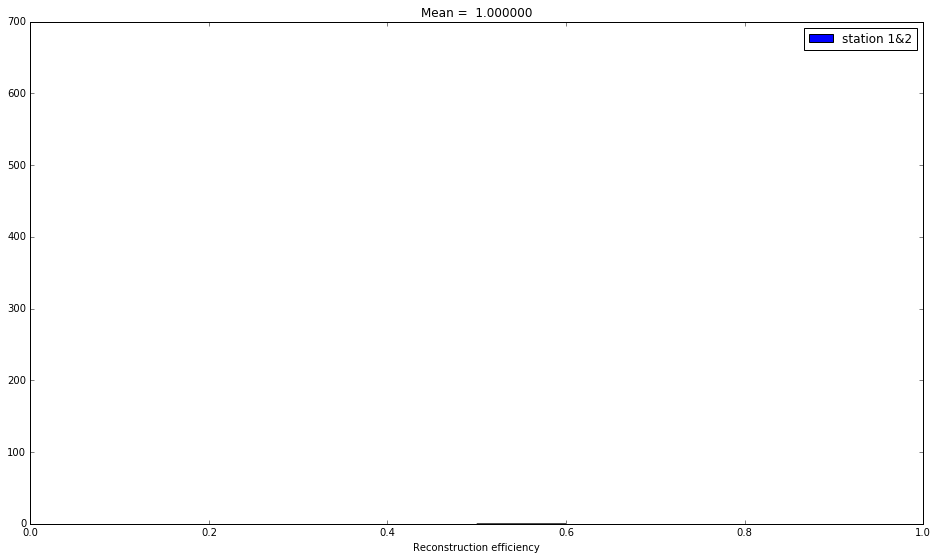

In [7]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

## track efficiency

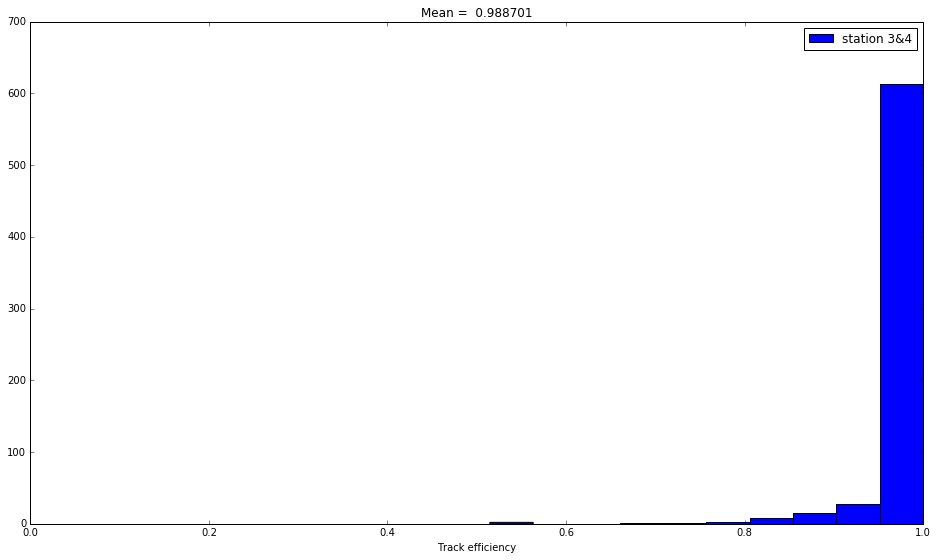

In [8]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

## reconstruction efficiency

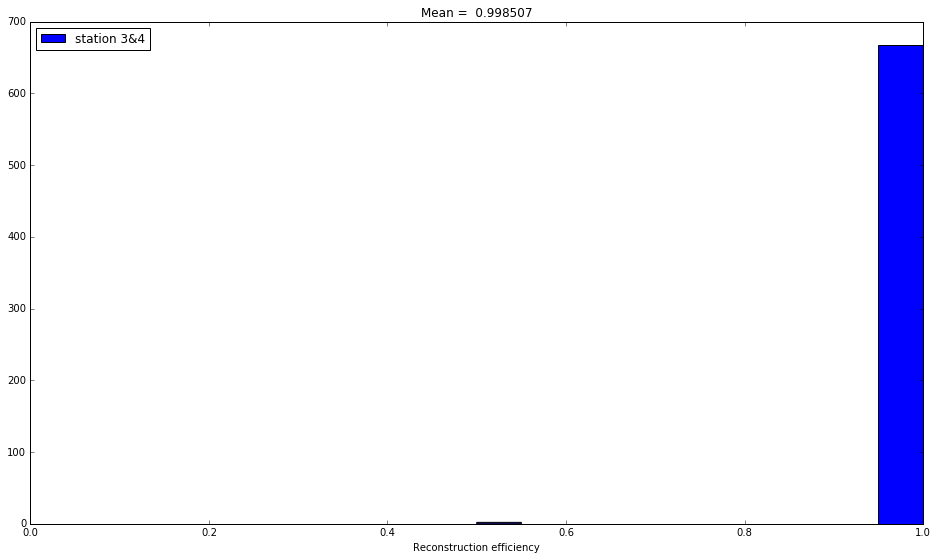

In [9]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

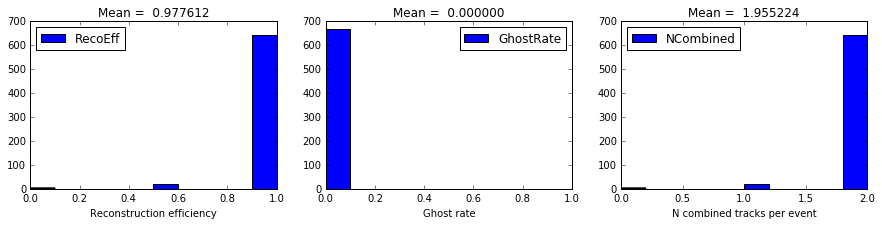

In [10]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

96.1194029851


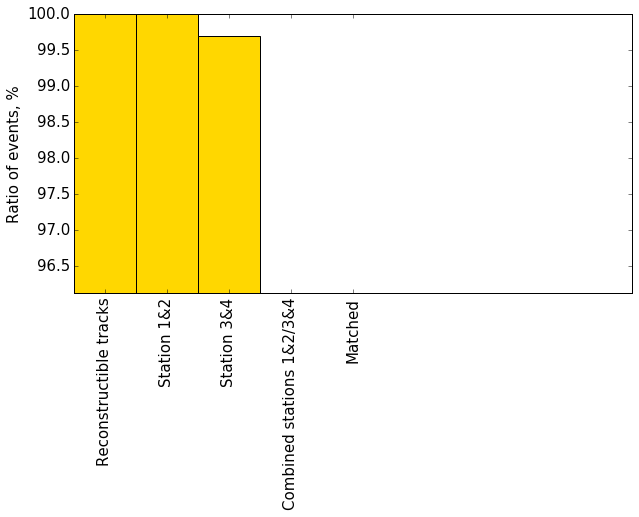

In [11]:
bar_labels = ['Reconstructible tracks', 
              'Station 1&2',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages.sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

# Momentum

In [12]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

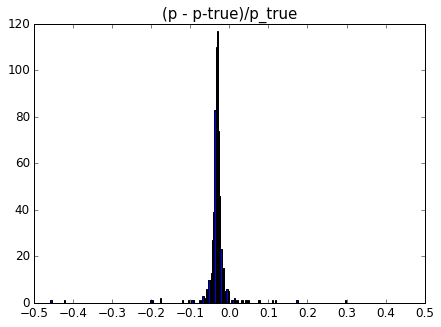

In [31]:
plt.figure(figsize=(7, 5))
plt.hist(p_err, bins=5000)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()